<a href="https://colab.research.google.com/github/zec1616/cyngua/blob/main/problem_set_3_Q3%2C_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests

In [ ]:
# 3a

import requests
import xml.etree.ElementTree as ET

def fetch_pubmed_ids(query, max_results=1000): # Set up API request
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results,
        "retmode": "xml"
    }
    # Send request and get response
    response = requests.get(base_url, params=params)

    print(f"Query URL: {response.url}")  # Print the full URL for debugging
    print(f"Response status code: {response.status_code}")

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        id_list = root.findall(".//Id")

        # Print the raw XML for debugging
        print("Raw XML response:")
        print(response.text[:500])  # Print first 500 characters of the response

        if not id_list:
            print("Warning: No IDs found in the response.")

        return [id_elem.text for id_elem in id_list]
    else:
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(f"Response content: {response.text}")
        return []

def save_ids_to_file(ids, filename):
    with open(filename, 'w') as f:
        for id in ids:
            f.write(f"{id}\n")

# Fetch PubMed IDs for Alzheimer's papers
print("\nFetching Alzheimer's papers...")
alzheimers_query = "Alzheimers AND 2023[pdat]"
alzheimers_ids = fetch_pubmed_ids(alzheimers_query)

# Fetch PubMed IDs for cancer papers
print("\nFetching cancer papers...")
cancer_query = "cancer AND 2023[pdat]"
cancer_ids = fetch_pubmed_ids(cancer_query)

print(f"\nNumber of Alzheimer's papers: {len(alzheimers_ids)}")
print(f"Number of cancer papers: {len(cancer_ids)}")

# Optional: Print the first few IDs for each category
print("\nFirst 5 Alzheimer's paper IDs:")
print(alzheimers_ids[:5])
print("\nFirst 5 cancer paper IDs:")
print(cancer_ids[:5])

# Save IDs to files
save_ids_to_file(alzheimers_ids, "alzheimers_ids.txt")
save_ids_to_file(cancer_ids, "cancer_ids.txt")

print("\nIDs saved to alzheimers_ids.txt and cancer_ids.txt")


Fetching Alzheimer's papers...
Query URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Alzheimers+AND+2023%5Bpdat%5D&retmax=1000&retmode=xml
Response status code: 200
Raw XML response:
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSearchResult PUBLIC "-//NLM//DTD esearch 20060628//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20060628/esearch.dtd">
<eSearchResult><Count>18485</Count><RetMax>1000</RetMax><RetStart>0</RetStart><IdList>
<Id>39359612</Id>
<Id>39351497</Id>
<Id>39329069</Id>
<Id>39329067</Id>
<Id>39328309</Id>
<Id>39309539</Id>
<Id>39308874</Id>
<Id>39291144</Id>
<Id>39280063</Id>
<Id>39239251</Id>
<Id>39206249</Id>
<Id>39195962</Id>
<Id>39157269</Id>
<Id>39

Fetching cancer papers...
Query URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=cancer+AND+2023%5Bpdat%5D&retmax=1000&retmode=xml
Response status code: 200
Raw XML response:
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSearchResult PUBLIC "-//NLM

Here I saved the paper IDs in txt files for further overlap analysis in 3c

In [ ]:
# 3b

import json
import time
from typing import List, Dict

BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

# Load PubMed IDs from a file
def load_pubmed_ids(file_path: str) -> List[str]:
    with open(file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Fetch metadata for a batch of PubMed IDs with retry mechanism
def fetch_metadata_batch(pmids: List[str], query: str, retries: int = 3) -> Dict[str, Dict[str, str]]:
    url = f"{BASE_URL}efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ",".join(pmids),
        "retmode": "xml"
    }

    for attempt in range(retries):
        try:
            # Send request to PubMed API
            response = requests.get(url, params=params)
            response.raise_for_status()
            root = ET.fromstring(response.content)

            metadata = {}
            # Extract metadata for each article
            for article in root.findall(".//PubmedArticle"):
                pmid = article.find(".//PMID").text
                title_elem = article.find(".//ArticleTitle")
                abstract_elem = article.find(".//AbstractText")

                # Extract title and abstract, use placeholders if not available
                title = ET.tostring(title_elem, method="text", encoding="unicode").strip() if title_elem is not None else "No title available"
                abstract = ET.tostring(abstract_elem, method="text", encoding="unicode").strip() if abstract_elem is not None else "No abstract available"

                metadata[pmid] = {
                    "ArticleTitle": title,
                    "AbstractText": abstract,
                    "query": query
                }
            return metadata
        except requests.RequestException as e:
            print(f"Error fetching metadata (attempt {attempt + 1}): {e}")
            if attempt < retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                print(f"Failed to fetch metadata for batch after {retries} attempts")
                return {}
        except ET.ParseError as e:
            print(f"Error parsing XML response: {e}")
            return {}

# Process a list of PubMed IDs in smaller batches
def process_ids(pmids: List[str], query: str, batch_size: int = 50) -> Dict[str, Dict[str, str]]:
    all_metadata = {}
    for i in range(0, len(pmids), batch_size):
        batch = pmids[i:i+batch_size]
        metadata = fetch_metadata_batch(batch, query)
        all_metadata.update(metadata)
        print(f"Processed {min(i+batch_size, len(pmids))} out of {len(pmids)} papers for {query}")
        time.sleep(1)
    return all_metadata

def main():
    # Load PubMed IDs from files
    alzheimers_ids = load_pubmed_ids("alzheimers_ids.txt")
    cancer_ids = load_pubmed_ids("cancer_ids.txt")

    print(f"Number of Alzheimer's IDs: {len(alzheimers_ids)}")
    print(f"Number of Cancer IDs: {len(cancer_ids)}")

    all_metadata = {}

    # Fetch metadata for Alzheimer's papers
    print("Fetching metadata for Alzheimer's papers...")
    alzheimers_metadata = process_ids(alzheimers_ids, "Alzheimer")
    all_metadata.update(alzheimers_metadata)

    # Fetch metadata for cancer papers
    print("\nFetching metadata for cancer papers...")
    cancer_metadata = process_ids(cancer_ids, "Cancer")
    all_metadata.update(cancer_metadata)

    print(f"\nTotal metadata entries: {len(all_metadata)}")

    # Save metadata to JSON file
    print("\nSaving metadata to JSON file...")
    with open("pubmed_metadata.json", "w", encoding="utf-8") as f:
        json.dump(all_metadata, f, ensure_ascii=False, indent=2)
    print("Metadata saved to pubmed_metadata.json")

if __name__ == "__main__":
    main()

Number of Alzheimer's IDs: 1000
Number of Cancer IDs: 1000
Fetching metadata for Alzheimer's papers...
Processed 50 out of 1000 papers for Alzheimer
Processed 100 out of 1000 papers for Alzheimer
Processed 150 out of 1000 papers for Alzheimer
Processed 200 out of 1000 papers for Alzheimer
Processed 250 out of 1000 papers for Alzheimer
Processed 300 out of 1000 papers for Alzheimer
Error fetching metadata (attempt 1): 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id=38247469%2C38247423%2C38246937%2C38243363%2C38241837%2C38241161%2C38241156%2C38241154%2C38239836%2C38239832%2C38239570%2C38239489%2C38239488%2C38239326%2C38239321%2C38239239%2C38236755%2C38235395%2C38235349%2C38235338%2C38235038%2C38234857%2C38234853%2C38234845%2C38234827%2C38234733%2C38234716%2C38234622%2C38234618%2C38231711%2C38230521%2C38229887%2C38229877%2C38229741%2C38229651%2C38229647%2C38229646%2C38227537%2C38227529%2C38227523%2C38227522%2C38227521%2C3822751

In [ ]:
# 3c

from typing import List, Set

def load_pubmed_ids(file_path: str) -> List[str]:
    # Load PubMed IDs from a file
    with open(file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def find_overlap(set1: Set[str], set2: Set[str]) -> Set[str]:
    # Find the overlap between two sets
    return set1.intersection(set2)

def main():
    # Load PubMed IDs from 3a
    alzheimer_ids = set(load_pubmed_ids("alzheimers_ids.txt"))
    cancer_ids = set(load_pubmed_ids("cancer_ids.txt"))

    # Find overlap
    overlapping_pmids = find_overlap(alzheimer_ids, cancer_ids)

    # Print concise results
    print(f"Overlapping papers: {len(overlapping_pmids)}")

    if overlapping_pmids:
        print("\nOverlapping PubMed IDs:")
        for pmid in overlapping_pmids:
            print(pmid)

if __name__ == "__main__":
    main()


Overlapping papers: 3

Overlapping PubMed IDs:
38694619
38948505
39280063


In [ ]:
# 3d

BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

def load_pubmed_ids(file_path: str) -> List[str]:
    # Load and return non-empty PubMed IDs from a file
    with open(file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def handle_structured_abstract(abstract_elem) -> str:
    # Process structured abstracts, combining all sections
    if abstract_elem is None:
        return "No abstract available"

    # Extract the text content of the AbstractText element,
    # converting it to a string and stripping whitespace
    abstract_parts = []
    for abstract_text in abstract_elem.findall(".//AbstractText"):
        label = abstract_text.get("Label", "")
        text = ET.tostring(abstract_text, method="text", encoding="unicode").strip()
        if label: # If there's a label, format the text with the label

            abstract_parts.append(f"{label}: {text}")
        else:     # If no label, just add the text as is
            abstract_parts.append(text)

    return " ".join(abstract_parts)

def fetch_metadata_batch(pmids: List[str], query: str, retries: int = 3) -> Dict[str, Dict[str, str]]:
    # Fetch metadata for a batch of PubMed IDs with retry mechanism
    url = f"{BASE_URL}efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ",".join(pmids),
        "retmode": "xml"
    }

    for attempt in range(retries):
        try:
            # Send request and parse XML response
            response = requests.get(url, params=params)
            response.raise_for_status()
            root = ET.fromstring(response.content)

            metadata = {}
            # Extract metadata for each article
            for article in root.findall(".//PubmedArticle"):
                pmid = article.find(".//PMID").text
                title_elem = article.find(".//ArticleTitle")
                abstract_elem = article.find(".//Abstract")

                title = ET.tostring(title_elem, method="text", encoding="unicode").strip() if title_elem is not None else "No title available"
                abstract = handle_structured_abstract(abstract_elem)

                metadata[pmid] = {
                    "ArticleTitle": title,
                    "AbstractText": abstract,
                    "query": query
                }
            return metadata
        except requests.RequestException as e:
            # Handle request errors with exponential backoff
            print(f"Error fetching metadata (attempt {attempt + 1}): {e}")
            if attempt < retries - 1:
                time.sleep(2 ** attempt)
            else:
                print(f"Failed to fetch metadata for batch after {retries} attempts")
                return {}
        except ET.ParseError as e:
            # Handle XML parsing errors
            print(f"Error parsing XML response: {e}")
            return {}

def process_ids(pmids: List[str], query: str, batch_size: int = 50) -> Dict[str, Dict[str, str]]:
    # Process PubMed IDs in batches
    all_metadata = {}
    for i in range(0, len(pmids), batch_size):
        batch = pmids[i:i+batch_size]
        metadata = fetch_metadata_batch(batch, query)
        all_metadata.update(metadata) # Update the all_metadata dictionary with the new batch results
        print(f"Processed {min(i+batch_size, len(pmids))} out of {len(pmids)} papers for {query}")
        time.sleep(1)
    return all_metadata

def main():
    # Load PubMed IDs for Alzheimer's and cancer
    alzheimers_ids = load_pubmed_ids("alzheimers_ids.txt")
    cancer_ids = load_pubmed_ids("cancer_ids.txt")

    print(f"Number of Alzheimer's IDs: {len(alzheimers_ids)}")
    print(f"Number of Cancer IDs: {len(cancer_ids)}")

    all_metadata = {}

    # Fetch metadata for Alzheimer's papers
    print("Fetching metadata for Alzheimer's papers...")
    alzheimers_metadata = process_ids(alzheimers_ids, "Alzheimer")
    all_metadata.update(alzheimers_metadata)

    # Fetch metadata for cancer papers
    print("\nFetching metadata for cancer papers...")
    cancer_metadata = process_ids(cancer_ids, "Cancer")
    all_metadata.update(cancer_metadata)

    print(f"\nTotal metadata entries: {len(all_metadata)}")

    # Save all metadata to JSON file
    print("\nSaving metadata to JSON file...")
    with open("pubmed_metadata.json", "w", encoding="utf-8") as f:
        json.dump(all_metadata, f, ensure_ascii=False, indent=2)
    print("Metadata saved to pubmed_metadata.json")

if __name__ == "__main__":
    main()

Number of Alzheimer's IDs: 1000
Number of Cancer IDs: 1000
Fetching metadata for Alzheimer's papers...
Error fetching metadata (attempt 1): 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id=39359612%2C39351497%2C39329069%2C39329067%2C39328309%2C39309539%2C39308874%2C39291144%2C39280063%2C39239251%2C39206249%2C39195962%2C39157269%2C39104675%2C39092005%2C39086663%2C39081998%2C39081993%2C39081991%2C39081990%2C39081988%2C39081987%2C39081985%2C39081983%2C39081981%2C39081980%2C39081979%2C39081978%2C39081977%2C39081974%2C39081972%2C39081970%2C39073326%2C39071742%2C39055175%2C39005867%2C38993793%2C38989946%2C38957268%2C38948505%2C38939864%2C38939735%2C38939405%2C38939404%2C38938237%2C38919750%2C38886936%2C38873169%2C38868579%2C38867816&retmode=xml
Processed 50 out of 1000 papers for Alzheimer
Processed 100 out of 1000 papers for Alzheimer
Processed 150 out of 1000 papers for Alzheimer
Processed 200 out of 1000 papers for Alzheimer
Err

# 3d - Limitations
1: It is not suitable for extremely large datasets that exceed available memory.

2: It extracts title and abstract that could miss other potentially useful metadata such as authors, publication date...

Loaded 1947 papers.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating SPECTER embeddings...


100%|██████████| 1947/1947 [40:37<00:00,  1.25s/it]


Performing PCA...
Creating scatter plots...


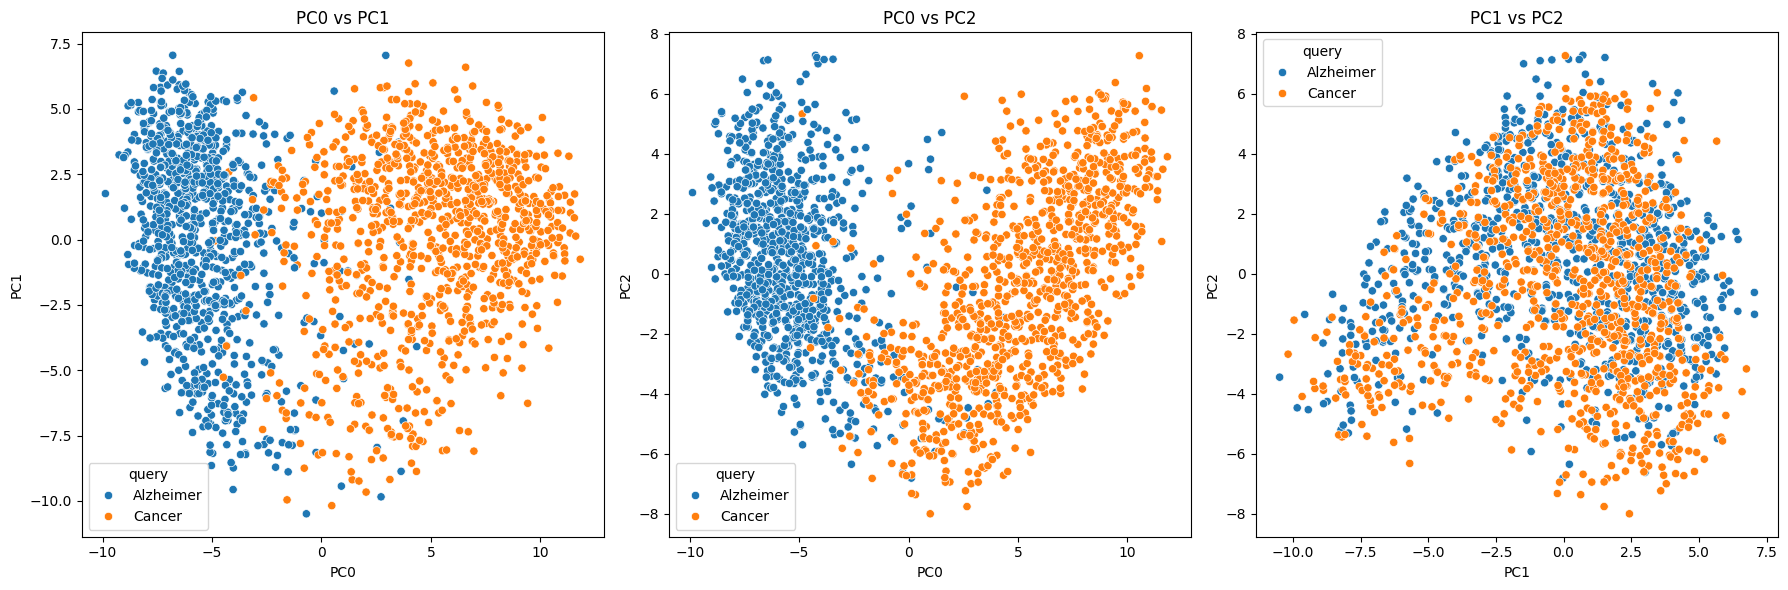

Explained variance ratios:
PC0: 0.1734
PC1: 0.0585
PC2: 0.0445
Analysis complete.


In [ ]:
# 4

import json
import torch
from transformers import AutoTokenizer, AutoModel
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Load the papers dictionary
def load_papers():
    with open('pubmed_metadata.json', 'r') as f:
        return json.load(f)

# Helper function to get abstract text
def get_abstract(paper):
    return paper.get('AbstractText', '')

# Generate SPECTER embeddings
def generate_embeddings(papers, tokenizer, model):
    embeddings = {}
    for pmid, paper in tqdm.tqdm(papers.items()): # Combine title and abstract for input
        data = [paper["ArticleTitle"] + tokenizer.sep_token + get_abstract(paper)]
        inputs = tokenizer(
            data, padding=True, truncation=True, return_tensors="pt", max_length=512
        )
        # Generate embedding
        with torch.no_grad():
            result = model(**inputs)
        # Store embedding
        embeddings[pmid] = result.last_hidden_state[:, 0, :].numpy()[0]
    return [embeddings[pmid] for pmid in papers.keys()]

# Perform PCA
def perform_pca(embeddings, n_components=3):
    pca = PCA(n_components=n_components)
    embeddings_pca = pd.DataFrame(
        pca.fit_transform(embeddings),
        columns=[f'PC{i}' for i in range(n_components)]
    )
    return embeddings_pca, pca

# Create scatter plots
def create_scatter_plots(embeddings_pca):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    pc_pairs = [('PC0', 'PC1'), ('PC0', 'PC2'), ('PC1', 'PC2')]

    for i, (pc_x, pc_y) in enumerate(pc_pairs):
        sns.scatterplot(data=embeddings_pca, x=pc_x, y=pc_y, hue='query', ax=axes[i])
        axes[i].set_title(f'{pc_x} vs {pc_y}')

    plt.tight_layout()
    plt.show()  # Display the plot

def main():
    # Load papers
    papers = load_papers()
    print(f"Loaded {len(papers)} papers.")

    # Load SPECTER model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
    model = AutoModel.from_pretrained('allenai/specter')

    # Generate embeddings
    print("Generating SPECTER embeddings...")
    embeddings = generate_embeddings(papers, tokenizer, model)

    # Perform PCA
    print("Performing PCA...")
    embeddings_pca, pca = perform_pca(embeddings)
    embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

    # Create scatter plots
    print("Creating scatter plots...")
    create_scatter_plots(embeddings_pca)

    # Print explained variance ratios for each principal component
    print("Explained variance ratios:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i}: {ratio:.4f}")

    print("Analysis complete.")

if __name__ == "__main__":
    main()


Conclusion & Analysis - Graph

1: CA analysis reveals that there are indeed distinct gene expression patterns that differentiate Alzheimer's papers from Cancer papers.

2: PC0 is the most effective at distinguishing between Alzheimer's and cancer papers. This suggests that the primary difference in the embeddings relates to the core subject matter of the papers.

3: PC1 and PC2 contribute to the differentiation but to a lesser extent. They might capture more nuanced aspects of the peopers that aren't as strongly tied to the main topic.

4: The overlap in the PC1 vs PC2 plot suggests that despite being different topics, Alzheimer's and cancer papers share some common features in their language or methodology, which is captured by these components.

Conclusion & Analysis - Variance

1: PC0 is by far the most important component, explaining about 3 times more variance than PC1 and nearly 4 times more than PC2, which aligns with our observation from the plots.

2: 7.34% + 5.85% + 4.45% = 27.64% of the total variance in the data.
suggest that the data is highly complex and multidimensional.


3: The relatively low total explained variance suggests that the SPECTER embeddings capture many nuanced aspects of the papers that aren't easily reduced to just a few dimensions.


